In [ ]:
For details on model details, see: https://mahowald.github.io/bayesian-ets/
- original code linked above is written in Julia Turing

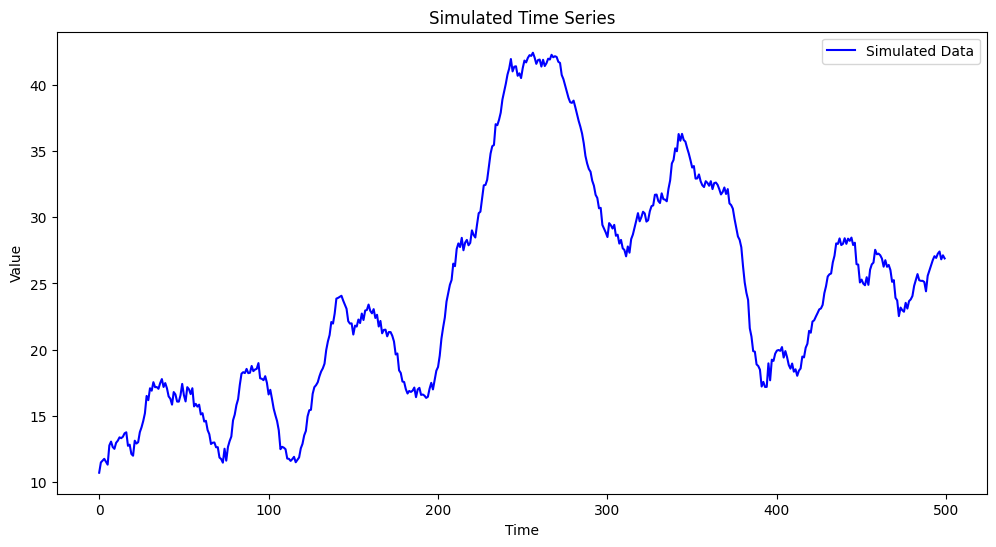

In [24]:
import numpy as np

def simulate_ets(alpha, beta, phi, sigma, length, l_init, b_init):
    """
    Simulate random walk with damped momentum and mean-reversion time series given parameters and initial states.

    Parameters:
        alpha (float): Smoothing parameter for the level.
        beta (float): Smoothing parameter for the trend.
        phi (float): Damping parameter for the trend.
        sigma (float): Standard deviation of the observation noise.
        length (int): Length of the time series to generate.
        l_init (float): Initial level.
        b_init (float): Initial trend.

    Returns:
        np.ndarray: Simulated time series data.
    """
    y = []
    l_t = l_init
    b_t = b_init

    for t in range(length):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Generate observation with noise
        y_t = y_hat_t + np.random.normal(0, sigma)
        y.append(y_t)

        # Update level and trend
        eps_t = y_t - y_hat_t
        l_t = l_t + phi * b_t + alpha * eps_t
        b_t = phi * b_t + alpha * beta * eps_t

    return np.array(y)

# Example parameters
alpha = 0.5  # Level smoothing
beta = 1   # Trend smoothing
phi = 0.8    # Trend damping
sigma = 0.5  # Observation noise
length = 500  # Length of the time series
l_init = 10.0  # Initial level
b_init = 0.5   # Initial trend

# Generate the simulated dataset
simulated_data = simulate_ets(alpha, beta, phi, sigma, length, l_init, b_init)

# Plot the simulated data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(simulated_data, label="Simulated Data", color="blue")
plt.title("Simulated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


C:\Users\jfuou\.pyenv\pyenv-win\versions\3.9.2\lib\site-packages\pymc\data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, phi_raw, sigma, l_init, b_init]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 133 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


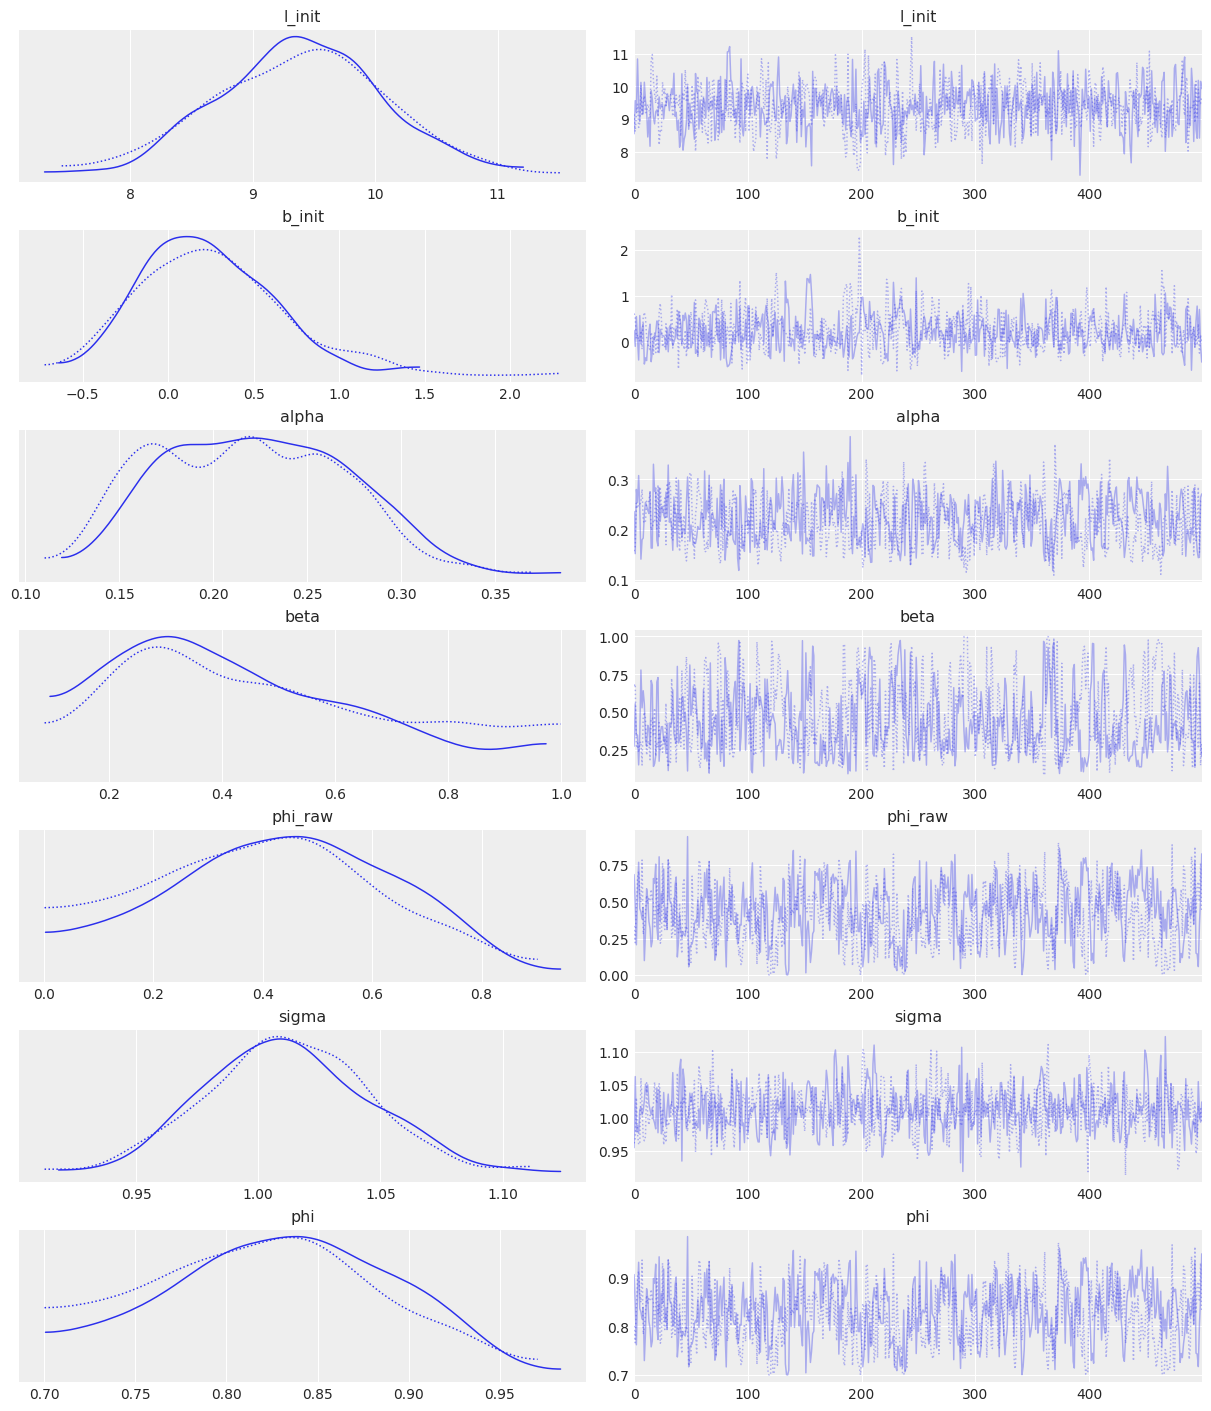

In [21]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pytensor

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

observed_data = simulated_data

def ets_step(y_t, l_prev, b_prev, alpha, beta, phi):
    # All parameters and inputs are float64.
    y_hat_t = l_prev + phi * b_prev
    eps_t = y_t - y_hat_t
    l_t = l_prev + phi * b_prev + alpha * eps_t
    b_t = phi * b_prev + alpha * beta * eps_t
    return l_t, b_t, y_hat_t

with pm.Model() as model_ets:
    # Observed data as a tensor variable
    y_tensor = pm.Data('y_data', observed_data)

    # Priors for parameters
    alpha = pm.Beta('alpha', alpha=1.0, beta=1.0)
    beta = pm.Beta('beta', alpha=1.0, beta=1.0)
    phi_raw = pm.Beta('phi_raw', alpha=1.0, beta=1.0)
    phi = pm.Deterministic('phi', 0.7 + 0.3 * phi_raw)
    #sigma = pm.HalfNormal('sigma', sigma=1.0)
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=1, lower=0, upper=np.inf)
    
    # Initial states
    l_init = pm.Normal('l_init', mu=y_tensor[0], sigma=1.0)
    b_init = pm.Normal('b_init', mu=0.0, sigma=1.0)

    # Use pytensor.scan to compute states and fitted values
    (l_seq, b_seq, y_hat_seq), _ = pytensor.scan(
        fn=ets_step,
        sequences=[y_tensor],
        outputs_info=[l_init, b_init, None],
        non_sequences=[alpha, beta, phi]
    )

    # Likelihood: observed data given the fitted values y_hat_seq
    pm.Normal('y_obs', mu=y_hat_seq, sigma=sigma, observed=y_tensor)

# Now we can sample from the posterior
with model_ets:
    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=42
    )

az.summary(trace)
az.plot_trace(trace)
plt.show()


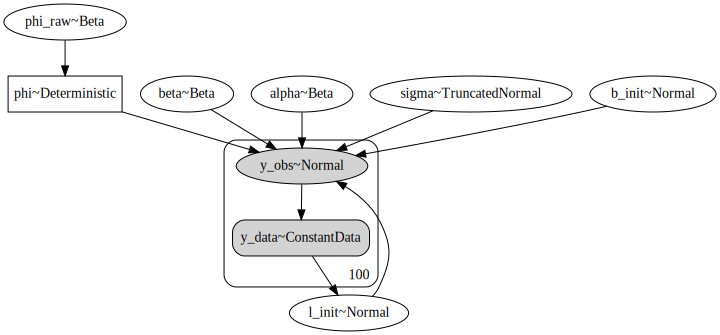

In [5]:
pm.model_to_graphviz(model_ets)

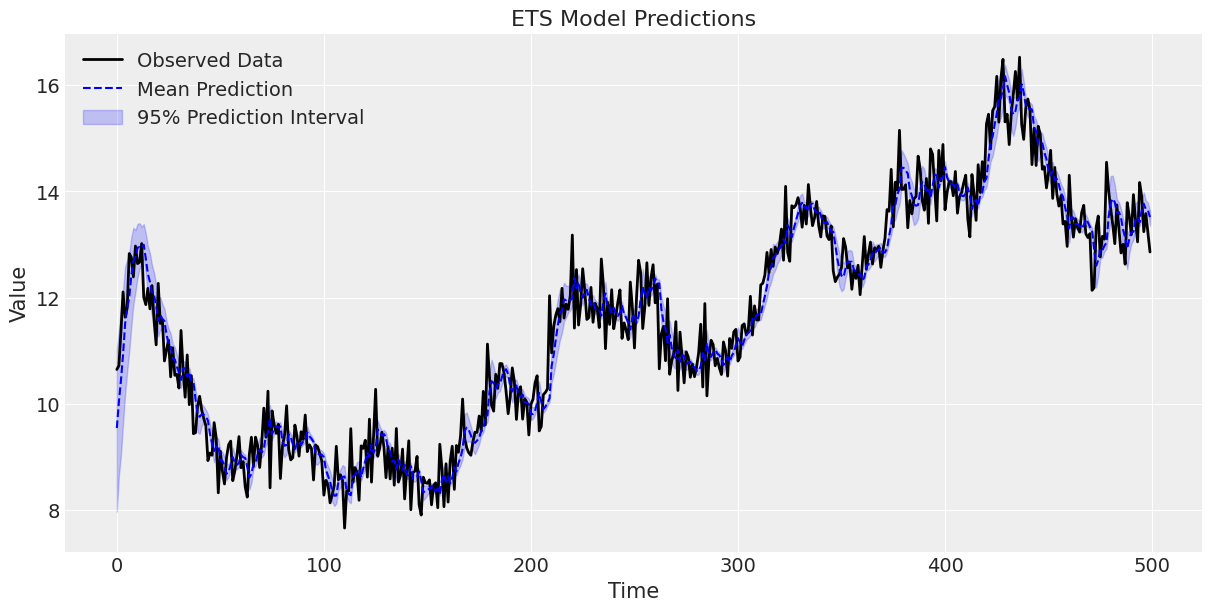

In [51]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate predictions using the posterior samples
def generate_predictions(trace, observed_data, num_samples=100):
    predictions = []
    length = len(observed_data)

    # Extract posterior samples
    alpha_samples = trace.posterior["alpha"].values.flatten()
    beta_samples = trace.posterior["beta"].values.flatten()
    phi_samples = trace.posterior["phi"].values.flatten()
    sigma_samples = trace.posterior["sigma"].values.flatten()
    l_init_samples = trace.posterior["l_init"].values.flatten()
    b_init_samples = trace.posterior["b_init"].values.flatten()

    for _ in range(num_samples):
        # Sample parameters from the posterior
        alpha_sample = np.random.choice(alpha_samples)
        beta_sample = np.random.choice(beta_samples)
        phi_sample = np.random.choice(phi_samples)
        sigma_sample = np.random.choice(sigma_samples)
        l_init_sample = np.random.choice(l_init_samples)
        b_init_sample = np.random.choice(b_init_samples)

        # Initialize the level and trend
        l_t = l_init_sample
        b_t = b_init_sample

        # Generate predictions iteratively
        y_hat = []
        for t in range(length):
            # Forecast
            y_hat_t = l_t + phi_sample * b_t
            y_hat.append(y_hat_t)

            # Update the states based on the observed data
            eps_t = observed_data[t] - y_hat_t
            l_t = l_t + phi_sample * b_t + alpha_sample * eps_t
            b_t = phi_sample * b_t + alpha_sample * beta_sample * eps_t

        predictions.append(y_hat)

    return np.array(predictions)

# Generate predictions
with model_ets:
    predictions = generate_predictions(trace, observed_data, num_samples=500)

# Compute prediction intervals
mean_prediction = predictions.mean(axis=0)
mean_sigma = np.mean(trace.posterior["sigma"].values.flatten())
lower_bound = np.percentile(predictions, 2.5, axis=0) #- 1.96*mean_sigma
upper_bound = np.percentile(predictions, 97.5, axis=0) #+ 1.96*mean_sigma

# Plot the observed data and predictions
plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black", linewidth=2)
plt.plot(mean_prediction, label="Mean Prediction", color="blue", linestyle="--")
plt.fill_between(
    np.arange(len(observed_data)),
    lower_bound,
    upper_bound,
    color="blue",
    alpha=0.2,
    label="95% Prediction Interval"
)
plt.legend()
plt.title("ETS Model Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


Optimized Parameters:
alpha: 0.9697, beta: 0.0080, phi: 0.7646, l_init: -0.2939, b_init: 1.0054


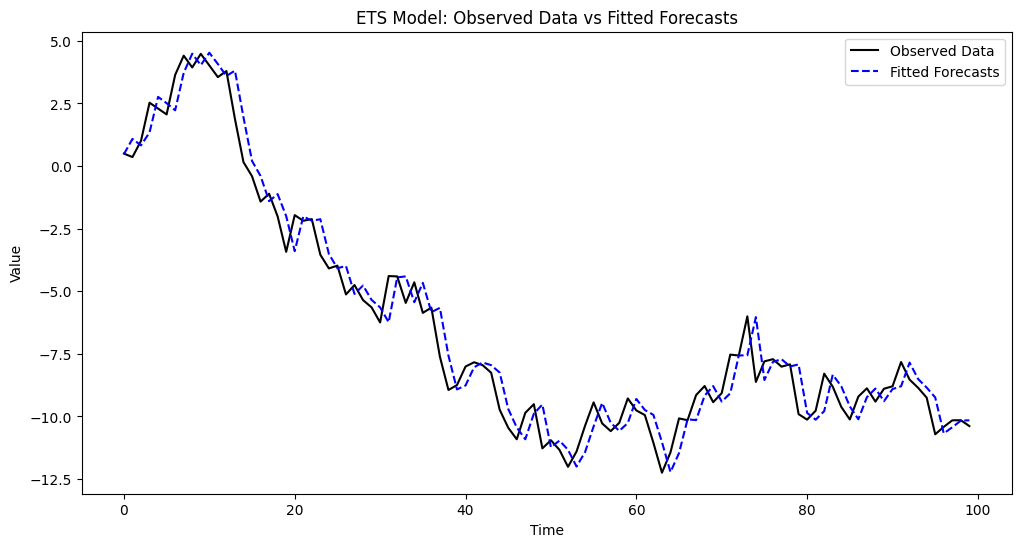

In [25]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate one-step-ahead forecasts and compute SSE
def ets_loss(params, y):
    """
    Calculate the loss (sum of squared errors) for ETS model given parameters.

    Parameters:
        params (array): Model parameters [alpha, beta, phi, l_init, b_init].
        y (array): Observed time series data.

    Returns:
        float: Sum of squared errors (SSE).
    """
    alpha, beta, phi, l_init, b_init = params
    n = len(y)
    l_t = l_init  # Initial level
    b_t = b_init  # Initial trend
    sse = 0.0

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Compute error
        error = y[t] - y_hat_t
        sse += error**2
        # Update level and trend
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return sse

# Simulated data for demonstration
np.random.seed(42)
length = 100
observed_data = np.cumsum(np.random.normal(0, 1, length))  # Random walk

# Initial guesses for the parameters
initial_guess = [0.5, 0.1, 0.9, observed_data[0], 0.1]  # alpha, beta, phi, l_init, b_init

# Bounds for parameters to ensure valid values
bounds = [
    (0, 1),  # alpha
    (0, 1),  # beta
    (0.7, 1),  # phi
    (None, None),  # l_init
    (None, None)   # b_init
]

# Perform optimization to minimize the loss function
result = minimize(ets_loss, initial_guess, args=(observed_data,), bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt = result.x

print("Optimized Parameters:")
print(f"alpha: {alpha_opt:.4f}, beta: {beta_opt:.4f}, phi: {phi_opt:.4f}, l_init: {l_init_opt:.4f}, b_init: {b_init_opt:.4f}")

# Forecasts using optimized parameters
def forecast_ets(alpha, beta, phi, l_init, b_init, y):
    n = len(y)
    l_t = l_init
    b_t = b_init
    forecasts = []

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        forecasts.append(y_hat_t)
        # Update level and trend
        error = y[t] - y_hat_t
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return np.array(forecasts)

# Generate one-step-ahead forecasts
forecasts = forecast_ets(alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, observed_data)

# Plot observed data vs forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(forecasts, label="Fitted Forecasts", color="blue", linestyle="--")
plt.legend()
plt.title("ETS Model: Observed Data vs Fitted Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


Optimized Parameters:
alpha: 0.4958, beta: 1.0000, phi: 0.8250, l_init: 10.5008, b_init: 0.5742, sigma: 0.5022


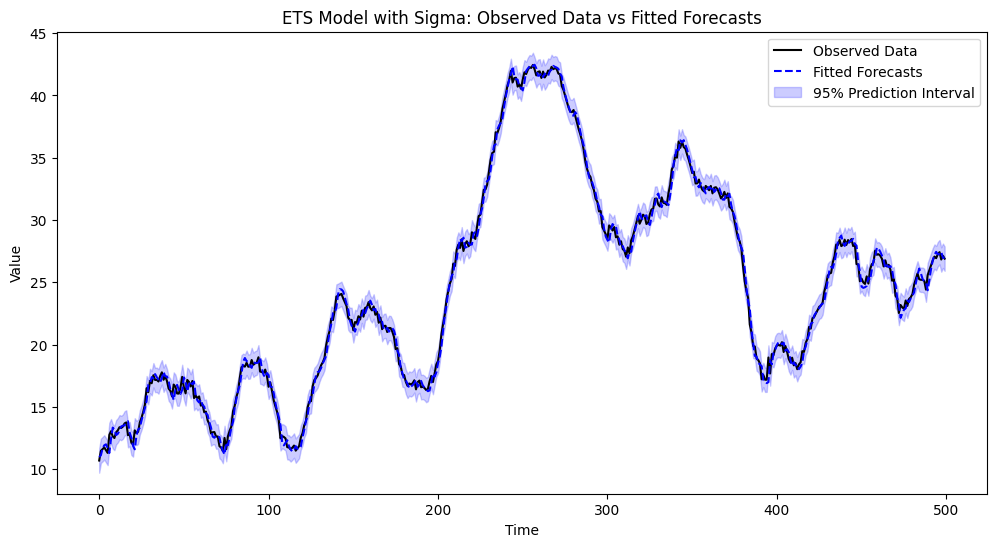

In [28]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate one-step-ahead forecasts and compute the log-likelihood
# This is a Maximum Likelihood Estimate loss that explicitly identifies the optimal sigma (noise / volatility) in conjunction with primary model parameters 
def ets_loss_with_sigma(params, y):
    """
    Calculate the negative log-likelihood for ETS model with noise (sigma).

    Parameters:
        params (array): Model parameters [alpha, beta, phi, l_init, b_init, sigma].
        y (array): Observed time series data.

    Returns:
        float: Negative log-likelihood.
    """
    alpha, beta, phi, l_init, b_init, sigma = params
    n = len(y)
    l_t = l_init  # Initial level
    b_t = b_init  # Initial trend

    log_likelihood = 0.0

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Compute error
        error = y[t] - y_hat_t
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * sigma**2) + (error**2) / (sigma**2))
        # Update level and trend
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return -log_likelihood  # Return negative log-likelihood for minimization

# Simulated data for demonstration
np.random.seed(42)
length = 100
#observed_data = np.cumsum(np.random.normal(0, 1, length))  # Random walk
observed_data = simulated_data

# Initial guesses for the parameters
initial_guess = [0.5, 0.1, 0.9, observed_data[0], 0.1, 1.0]  # alpha, beta, phi, l_init, b_init, sigma

# Bounds for parameters to ensure valid values
bounds = [
    (0, 1),    # alpha
    (0, 1),    # beta
    (0.7, 1),  # phi
    (None, None),  # l_init
    (None, None),  # b_init
    (1e-5, None)   # sigma > 0
]

# Perform optimization to minimize the negative log-likelihood
result = minimize(ets_loss_with_sigma, initial_guess, args=(observed_data,), bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt = result.x

print("Optimized Parameters:")
print(f"alpha: {alpha_opt:.4f}, beta: {beta_opt:.4f}, phi: {phi_opt:.4f}, l_init: {l_init_opt:.4f}, b_init: {b_init_opt:.4f}, sigma: {sigma_opt:.4f}")

# Forecasts using optimized parameters
def forecast_ets_with_sigma(alpha, beta, phi, l_init, b_init, sigma, y):
    n = len(y)
    l_t = l_init
    b_t = b_init
    forecasts = []

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        forecasts.append(y_hat_t)
        # Update level and trend
        error = y[t] - y_hat_t
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return np.array(forecasts)

# Generate one-step-ahead forecasts
forecasts = forecast_ets_with_sigma(alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt, observed_data)

# Plot observed data vs forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(forecasts, label="Fitted Forecasts", color="blue", linestyle="--")
plt.fill_between(
    np.arange(len(observed_data)),
    observed_data-1.95*sigma_opt,
    observed_data+1.95*sigma_opt,
    color="blue",
    alpha=0.2,
    label="95% Prediction Interval"
)
plt.legend()
plt.title("ETS Model with Sigma: Observed Data vs Fitted Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [239]:
import yfinance as yf

spy_data_1d = yf.Ticker('SPY').history(interval="1d", start='2024-01-01')['Close']
spy_data_5d = yf.Ticker('SPY').history(interval="5d", start='2022-01-01')['Close']
spy_data_1m = yf.Ticker('SPY').history(interval="1mo", start='2018-01-01')['Close']
spy_data_3m = yf.Ticker('SPY').history(interval="3mo", start='2004-01-01')['Close']
#plt.plot(df.values)

Optimized Parameters:
alpha: 0.5129, beta: 0.7608, phi: 0.8594, l_init: 2.3570, b_init: 0.0417, sigma: 0.0264
MAPE[train]: 1.9137445523387449
Naive-MAPE[train]: 2.2479830741060582
MAPE[test]: 1.65237088375386
Naive-MAPE[test]: 1.808767194101802


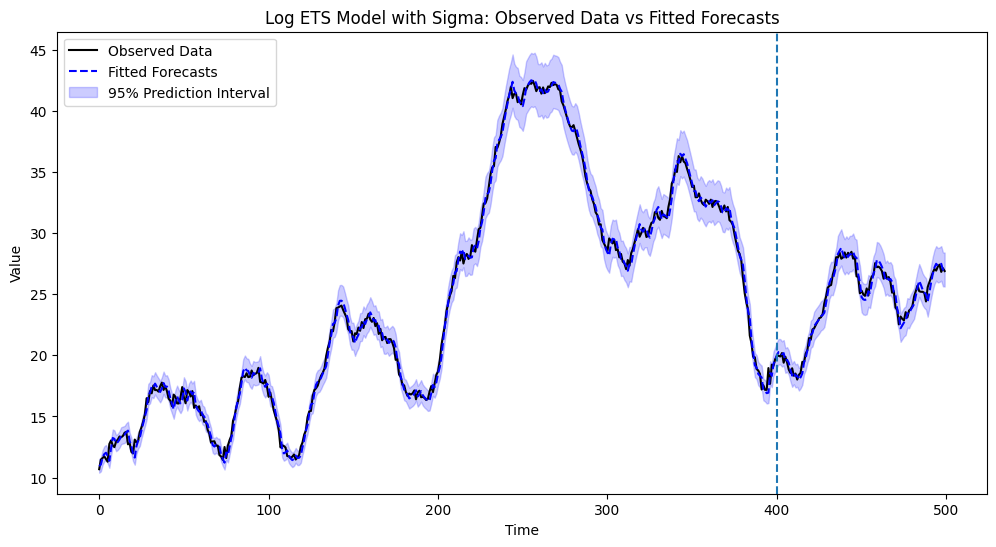

In [94]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate one-step-ahead forecasts and compute the log-likelihood
# This is a Maximum Likelihood Estimate loss that explicitly identifies the optimal sigma (volatility) in conjunction with primary model parameters 
def ets_loss_with_sigma(params, y):
    """
    Calculate the negative log-likelihood for ETS model with noise (sigma).

    Parameters:
        params (array): Model parameters [alpha, beta, phi, l_init, b_init, sigma].
        y (array): Observed time series data.

    Returns:
        float: Negative log-likelihood.
    """
    alpha, beta, phi, l_init, b_init, sigma = params
    n = len(y)
    l_t = l_init  # Initial level
    b_t = b_init  # Initial trend

    log_likelihood = 0.0

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Compute error
        error = y[t] - y_hat_t
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * sigma**2) + (error**2) / (sigma**2))
        # Update level and trend
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return -log_likelihood  # Return negative log-likelihood for minimization

observed_data = simulated_data#spy_data_1d.values
log_observed_data =  np.log(observed_data)

n = len(observed_data)
train_split_ratio = 0.8
train_n = int(train_split_ratio * n)

train, test = observed_data[:train_n], observed_data[train_n:]

log_train = np.log(train)

# Initial guesses for the parameters
initial_guess = [0.5, 0.1, 0.9, log_train[0], 0.1, 0.1]  # alpha, beta, phi, l_init, b_init, sigma

# Bounds for parameters to ensure valid values
bounds = [
    (0, 1),    # alpha
    (0., 1),    # beta
    (0.7, 1),  # phi
    (None, None),  # l_init
    (None, None),  # b_init
    (1e-5, None)   # sigma > 0
]

# Perform optimization to minimize the negative log-likelihood
result = minimize(ets_loss_with_sigma, initial_guess, args=(log_train,), bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt = result.x

print("Optimized Parameters:")
print(f"alpha: {alpha_opt:.4f}, beta: {beta_opt:.4f}, phi: {phi_opt:.4f}, l_init: {l_init_opt:.4f}, b_init: {b_init_opt:.4f}, sigma: {sigma_opt:.4f}")

# Forecasts using optimized parameters
def forecast_ets_with_sigma(alpha, beta, phi, l_init, b_init, sigma, y):
    n = len(y)
    l_t = l_init
    b_t = b_init
    
    forecasts = []
    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        forecasts.append(y_hat_t)
        # Update level and trend
        error = y[t] - y_hat_t
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + alpha * beta * error

    return np.array(forecasts)

# Generate one-step-ahead forecasts
log_forecasts = forecast_ets_with_sigma(alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt, log_observed_data )

forecasts = np.exp(log_forecasts)
lower = np.exp(log_forecasts-1.95*sigma_opt)
upper = np.exp(log_forecasts+1.95*sigma_opt)

MAPE_train = 100.*np.mean( np.abs(forecasts[:train_n]-observed_data[:train_n])/observed_data[:train_n] )
Niave_MAPE_train = 100. * np.mean( np.abs(observed_data[1:train_n]-observed_data[:train_n-1])/observed_data[1:train_n] )
print("MAPE[train]:", MAPE_train)
print("Naive-MAPE[train]:", Niave_MAPE_train)

MAPE_test = 100.*np.mean( np.abs(forecasts[train_n:]-observed_data[train_n:])/observed_data[train_n:] )
Niave_MAPE_test = 100. * np.mean( np.abs(observed_data[train_n+1:]-observed_data[train_n:-1])/observed_data[train_n+1:] )
print("MAPE[test]:", MAPE_test)
print("Naive-MAPE[test]:", Niave_MAPE_test)

# Plot observed data vs forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(forecasts, label="Fitted Forecasts", color="blue", linestyle="--")
plt.fill_between(
    np.arange(len(observed_data)),
    lower,
    upper,
    color="blue",
    alpha=0.2,
    label="95% Prediction Interval"
)
plt.axvline(x=train_n, linestyle='--')

plt.legend()
plt.title("Log ETS Model with Sigma: Observed Data vs Fitted Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


Optimized Parameters:
alpha: 0.3705, beta: 0.1633, phi: 1.0000, l_init: 62.5355, b_init: 3.6275, sigma: 14.5594
MAPE[train]: 5.841530733784424
Naive-MAPE[train]: 7.0376552742506915
PCT-Relative-Accuracy-Improvement[train]: 16.996066073918637
MAPE[test]: 14.467783745359434
Naive-MAPE[test]: 8.550136237431254
PCT-Relative-Accuracy-Improvement[test]: -69.2111487302574


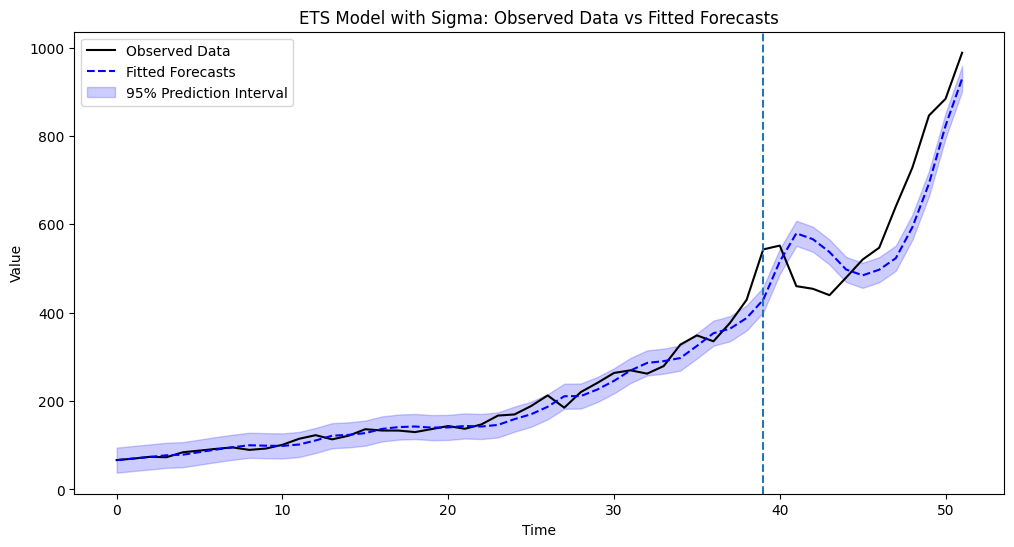

In [219]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate one-step-ahead forecasts and compute the log-likelihood
# This is a Maximum Likelihood Estimate loss that explicitly identifies the optimal sigma (volatility) in conjunction with primary model parameters 
def ets_loss_with_sigma(params, y):
    """
    Calculate the negative log-likelihood for ETS model with noise (sigma).

    Parameters:
        params (array): Model parameters [alpha, beta, phi, l_init, b_init, sigma].
        y (array): Observed time series data.

    Returns:
        float: Negative log-likelihood.
    """
    alpha, beta, phi, l_init, b_init, sigma = params
    n = len(y)
    l_t = l_init  # Initial level
    b_t = b_init  # Initial trend

    log_likelihood = 0.0

    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Compute error
        error = y[t] - y_hat_t
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * sigma**2) + (error**2) / (sigma**2))
        # Update level and trend
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t + beta * error

    return -log_likelihood  # Return negative log-likelihood for minimization

# Forecasts using optimized parameters
def forecast_ets_with_sigma(alpha, beta, phi, l_init, b_init, sigma, y):
    n = len(y)
    l_t = l_init
    b_t = b_init
    
    forecasts = []
    for t in range(n):
        # Forecast
        y_hat_t = l_t + phi * b_t
        # Update level and trend
        error = y[t] - y_hat_t
        forecasts.append(y_hat_t)
        l_t = l_t + phi * b_t + alpha * error
        b_t = phi * b_t +  beta * error

    return np.array(forecasts)


observed_data = spy_data_3m.values

n = len(observed_data)
train_split_ratio = 0.75
train_n = int(train_split_ratio * n)

train, test = observed_data[:train_n], observed_data[train_n:]

# Initial guesses for the parameters
initial_guess = [0.5, 0.1, 0.9, train[0], 0.1, 0.1]  # alpha, beta, phi, l_init, b_init, sigma

# Bounds for parameters to ensure valid values
bounds = [
    (0, 1),    # alpha
    (0., 1),    # beta
    (0.7, 1),  # phi
    (None, None),  # l_init
    (None, None),  # b_init
    (1e-5, None)   # sigma > 0
]

# Perform optimization to minimize the negative log-likelihood
result = minimize(ets_loss_with_sigma, initial_guess, args=(train,), bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt = result.x

print("Optimized Parameters:")
print(f"alpha: {alpha_opt:.4f}, beta: {beta_opt:.4f}, phi: {phi_opt:.4f}, l_init: {l_init_opt:.4f}, b_init: {b_init_opt:.4f}, sigma: {sigma_opt:.4f}")

# Generate one-step-ahead forecasts
forecasts = forecast_ets_with_sigma(alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt, observed_data )

lower = forecasts-1.95*sigma_opt
upper = forecasts+1.95*sigma_opt

MAPE_train = 100.*np.mean( np.abs(forecasts[:train_n]-observed_data[:train_n])/observed_data[:train_n] )
Niave_MAPE_train = 100. * np.mean( np.abs(observed_data[1:train_n]-observed_data[:train_n-1])/observed_data[1:train_n] )
print("MAPE[train]:", MAPE_train)
print("Naive-MAPE[train]:", Niave_MAPE_train)
print("PCT-Relative-Accuracy-Improvement[train]:", 100.*(Niave_MAPE_train-MAPE_train)/Niave_MAPE_train)

MAPE_test = 100.*np.mean( np.abs(forecasts[train_n:]-observed_data[train_n:])/observed_data[train_n:] )
Niave_MAPE_test = 100. * np.mean( np.abs(observed_data[train_n+1:]-observed_data[train_n:-1])/observed_data[train_n+1:] )
print("MAPE[test]:", MAPE_test)
print("Naive-MAPE[test]:", Niave_MAPE_test)
print("PCT-Relative-Accuracy-Improvement[test]:", 100.*(Niave_MAPE_test-MAPE_test)/Niave_MAPE_test)


plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(forecasts, label="Fitted Forecasts", color="blue", linestyle="--")
plt.fill_between(
    np.arange(len(observed_data)),
    lower,
    upper,
    color="blue",
    alpha=0.2,
    label="95% Prediction Interval"
)
plt.axvline(x=train_n, linestyle='--')

plt.legend()
plt.title("ETS Model with Sigma: Observed Data vs Fitted Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


MAPE[naive]: 4.287345422204015
MAPE[Adaptive]: 4.890303435607916


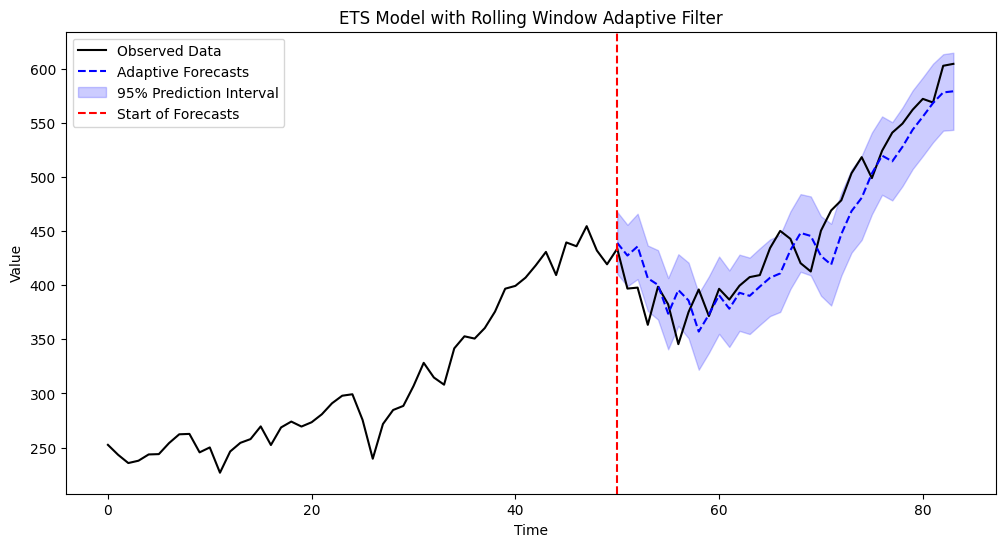

In [243]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Rolling window size
rolling_window_size = 50  # Size of the rolling window for parameter re-optimization
observed_data = spy_data_1m.values

# Adaptive forecast function with rolling window
def adaptive_forecast_with_rolling_window(data, window_size, initial_guess, bounds):
    """
    Perform adaptive forecasting using a rolling window approach.

    Parameters:
        data (np.ndarray): Time series data.
        window_size (int): Size of the rolling window for parameter optimization.
        initial_guess (list): Initial guesses for the ETS parameters.
        bounds (list): Bounds for parameter optimization.

    Returns:
        np.ndarray: Forecasted values.
    """
    n = len(data)
    forecasts = []
    lower_bounds = []
    upper_bounds = []

    # Initialize parameters for the first window
    current_guess = initial_guess

    for t in range(window_size, n):
        # Define the rolling window
        rolling_data = data[t - window_size:t]

        # Re-optimize parameters using the rolling window
        result = minimize(
            ets_loss_with_sigma,
            current_guess,
            args=(rolling_data,),
            bounds=bounds,
            method='L-BFGS-B'
        )

        # Update parameters with the optimized values
        current_guess = result.x
        alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt = current_guess

        # Forecast for the next time step
        forecast = forecast_ets_with_sigma(
            alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt, rolling_data
        )[-1]

        # Append forecast and prediction interval
        forecasts.append(forecast)
        lower_bounds.append(forecast - 1.95 * sigma_opt)
        upper_bounds.append(forecast + 1.95 * sigma_opt)

    return np.array(forecasts), np.array(lower_bounds), np.array(upper_bounds)

# Perform adaptive forecasting
forecasts, lower_bounds, upper_bounds = adaptive_forecast_with_rolling_window(
    observed_data, rolling_window_size, initial_guess, bounds
)

# Extend forecasts to align with observed data
forecasts_full = np.concatenate([np.full(rolling_window_size, np.nan), forecasts])
lower_full = np.concatenate([np.full(rolling_window_size, np.nan), lower_bounds])
upper_full = np.concatenate([np.full(rolling_window_size, np.nan), upper_bounds])

naive_MAPE = 100. * np.mean(np.abs(observed_data[rolling_window_size-1:-1] - observed_data[rolling_window_size:]) / observed_data[rolling_window_size-1:-1])
print("MAPE[naive]:", naive_MAPE)

# Compute MAPE for adaptive forecasts
adaptive_MAPE = 100. * np.mean(np.abs(forecasts - observed_data[rolling_window_size:]) / observed_data[rolling_window_size:])
print("MAPE[Adaptive]:", adaptive_MAPE)

# Plot observed data, forecasts, and prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(forecasts_full, label="Adaptive Forecasts", color="blue", linestyle="--")
plt.fill_between(
    np.arange(len(observed_data)),
    lower_full,
    upper_full,
    color="blue",
    alpha=0.2,
    label="95% Prediction Interval"
)
plt.axvline(x=rolling_window_size, linestyle='--', color='red', label='Start of Forecasts')
plt.legend()
plt.title("ETS Model with Rolling Window Adaptive Filter")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [225]:
len(observed_data[rolling_window_size:]) - len(forecasts)

0

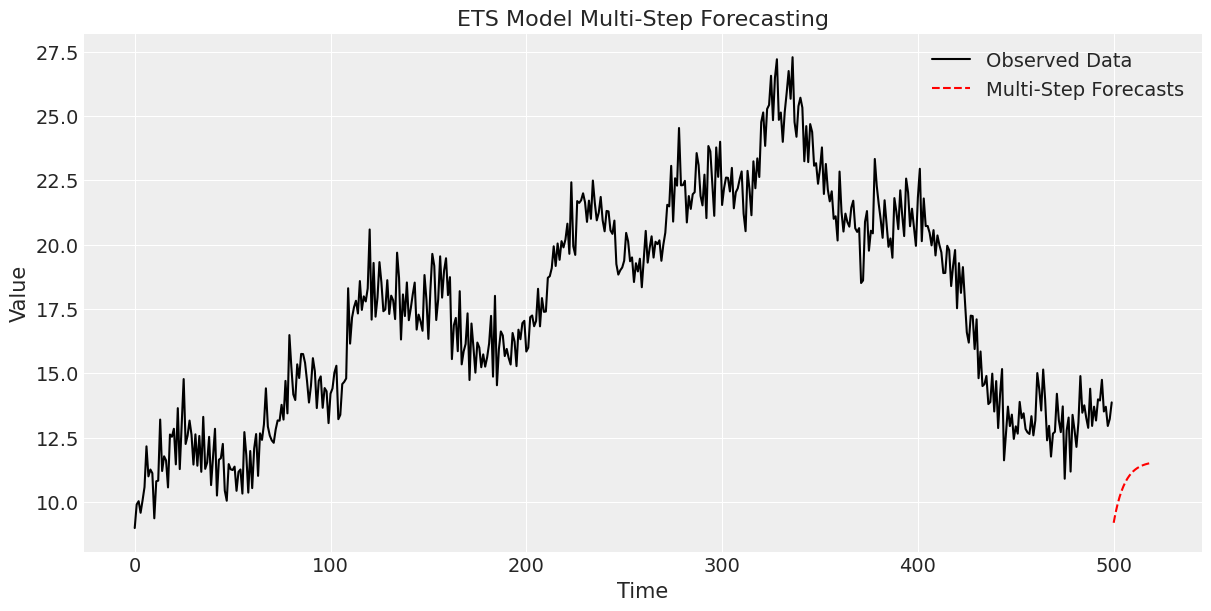

In [27]:
def multi_step_forecast(alpha, beta, phi, l_init, b_init, sigma, steps):
    """
    Perform multi-step forecasting using the ETS model.

    Parameters:
        alpha (float): Smoothing parameter for the level.
        beta (float): Smoothing parameter for the trend.
        phi (float): Damping parameter for the trend.
        l_init (float): Initial level.
        b_init (float): Initial trend.
        sigma (float): Observation noise standard deviation.
        steps (int): Number of steps to forecast.

    Returns:
        np.ndarray: Forecasted values for the specified steps.
    """
    l_t = l_init
    b_t = b_init
    forecasts = []

    for _ in range(steps):
        # Forecast
        y_hat_t = l_t + phi * b_t
        forecasts.append(y_hat_t)
        
        # Update level and trend (no actual observation available)
        l_t = l_t + phi * b_t
        b_t = phi * b_t

    return np.array(forecasts)

# Multi-step forecast example
forecast_steps = 20  # Forecast 20 steps into the future
multi_step_forecasts = multi_step_forecast(
    alpha_opt, beta_opt, phi_opt, l_init_opt, b_init_opt, sigma_opt, forecast_steps
)

# Extend the observed data for plotting
extended_time = np.arange(len(observed_data) + forecast_steps)
observed_with_forecasts = np.concatenate([observed_data, [np.nan] * forecast_steps])

# Plot observed data and multi-step forecasts
plt.figure(figsize=(12, 6))
plt.plot(observed_data, label="Observed Data", color="black")
plt.plot(
    np.arange(len(observed_data), len(observed_data) + forecast_steps),
    multi_step_forecasts,
    label="Multi-Step Forecasts",
    color="red",
    linestyle="--",
)
plt.legend()
plt.title("ETS Model Multi-Step Forecasting")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()
